<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Crypto_of_the_Hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Reading data from https://s3.amazonaws.com/public.gillerinvestments.com/crypto-of-the-hour.json.
                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.787
Date:                Mon, 27 Dec 2021   Prob (F-statistic):              0.182
Time:                        13:54:55   Log-Likelihood:                -457.14
No. Observations:                 425   AIC:                             918.3
Df Residuals:                     423   BIC:                             926.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

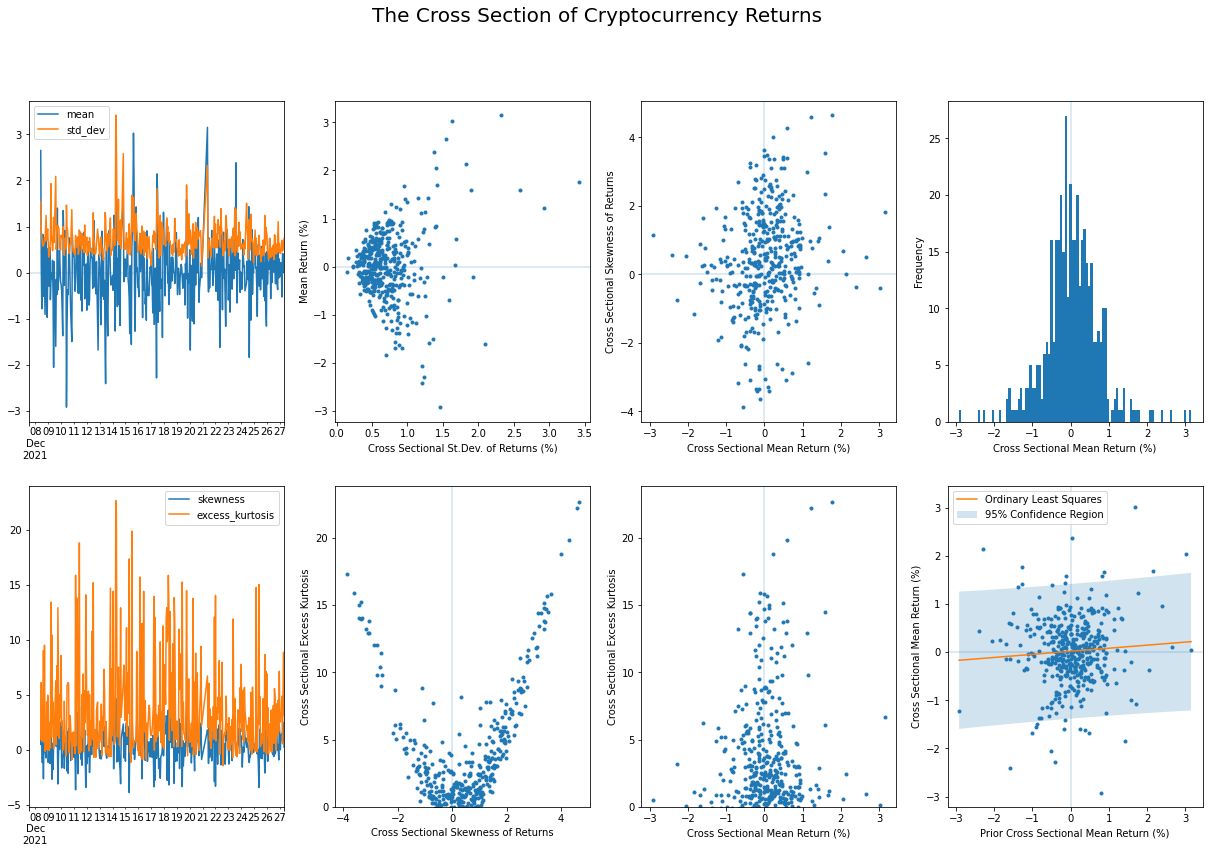

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot ; golden_ratio=(1e0+np.sqrt(5e0))/2e0
from requests import get
from json import loads
from statsmodels.formula.api import ols as OLS
from statsmodels.sandbox.regression.predstd import wls_prediction_std

variant=''
source='https://s3.amazonaws.com/public.gillerinvestments.com/%scrypto-of-the-hour.json' % (variant+'-' if variant else '');
print("Reading data from %s." % source);
page=get(source);

if page.status_code/100!=2:
    raise ValueError("Return code %d from %s." % page.status_code);

data=pd.DataFrame(loads(page.text)['history']);
data.drop(["2021-12-14 17:00:03","2021-12-14 18:00:07"] if '.com/crypto' in source \
     else ["2021-12-21 09:03:32","2021-12-21 09:31:01","2021-12-21 10:31:07","2021-12-21 11:31:01","2021-12-21 12:31:02"],inplace=True); # special fix for historic price glitches
data.index=pd.PeriodIndex(data.index,freq='h')
data["mean_lagged"]=data["mean"].shift()
fit=OLS("mean ~ mean_lagged",data.dropna()).fit()
title="$(\\alpha=%.3f\\pm%.3f,\\beta=%.3f\\pm%.3f)$" % (fit.params[0],fit.bse[0],fit.params[1],fit.bse[1])
print(fit.summary())
alphacrit=0.05
x,y,f=data.dropna()["mean_lagged"].tolist(),data.dropna()["mean"].tolist(),fit.fittedvalues
sig,crl,cru,=wls_prediction_std(fit,alpha=alphacrit)
x,y,f,crl,cru=tuple(zip(*list(sorted(zip(x,y,f,crl,cru),key=lambda a:a[0]))))

figure,plots=plot.subplots(2,4,figsize=(13*golden_ratio,13));
data[["mean","std_dev"]].plot(ax=plots[0][0]);
plots[0][0].axhline(0,alpha=0.2);
data[["skewness","excess_kurtosis"]].plot(ax=plots[1][0]);
plots[0][1].plot(data["std_dev"],data["mean"],'.');
plots[0][1].set_xlabel('Cross Sectional St.Dev. of Returns (%)');
plots[0][1].set_ylabel('Mean Return (%)');
plots[0][1].axhline(0,alpha=0.2);
plots[1][1].plot(data["skewness"],data["excess_kurtosis"],'.');
plots[1][1].set_xlabel("Cross Sectional Skewness of Returns");
plots[1][1].set_ylabel("Cross Sectional Excess Kurtosis");
plots[1][1].axvline(0,alpha=0.2);
plots[1][1].set_ylim(0,None);
plots[0][2].plot(data["mean"],data["skewness"],'.');
plots[0][2].set_xlabel("Cross Sectional Mean Return (%)");
plots[0][2].set_ylabel("Cross Sectional Skewness of Returns");
plots[0][2].axhline(0,alpha=0.2);
plots[0][2].axvline(0,alpha=0.2);
plots[1][2].plot(data["mean"],data["excess_kurtosis"],'.');
plots[1][2].set_xlabel("Cross Sectional Mean Return (%)");
plots[1][2].set_ylabel("Cross Sectional Excess Kurtosis");
plots[1][2].axvline(0,alpha=0.2);
plots[1][2].set_ylim(0,None);
plots[0][3].hist(data["mean"],bins=np.linspace(data["mean"].min(),data["mean"].max(),100));
plots[0][3].set_xlabel("Cross Sectional Mean Return (%)");
plots[0][3].set_ylabel("Frequency");
plots[0][3].axvline(0,alpha=0.2);
plots[1][3].plot(x,y,'.');
plots[1][3].set_xlabel("Prior Cross Sectional Mean Return (%)");
plots[1][3].set_ylabel("Cross Sectional Mean Return (%)");
plots[1][3].plot(x,f,'-',label='Ordinary Least Squares');
plots[1][3].fill_between(x,crl,cru,alpha=0.2,label='%.0f%% Confidence Region' % (1e2-1e2*alphacrit));
plots[1][3].axhline(0,alpha=0.2);
plots[1][3].axvline(0,alpha=0.2);
plots[1][3].legend(loc='best')
figure.suptitle("The Cross Section of Cryptocurrency Returns",fontsize=20);

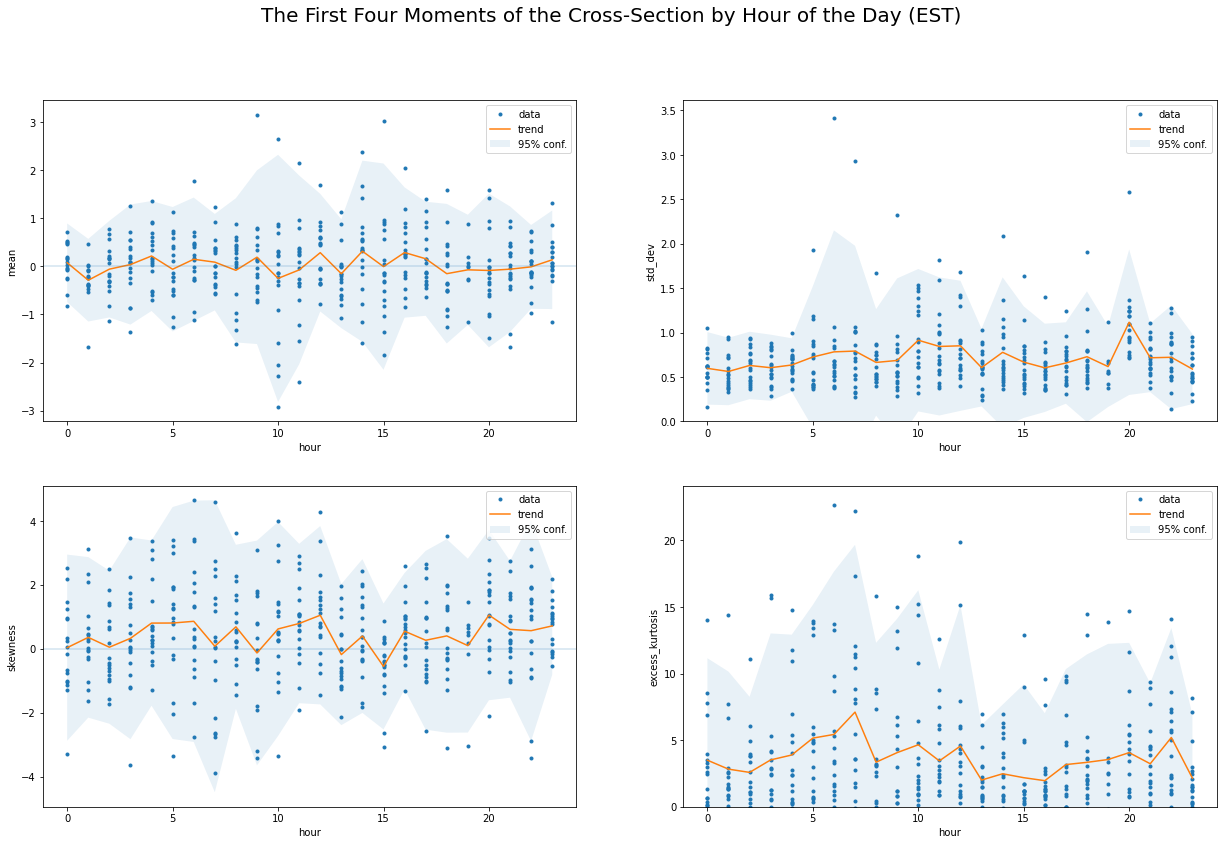

In [ ]:
figure,plots=plot.subplots(2,2,figsize=(13*golden_ratio,13));
i=0
data["hour"]=data.index.hour

for metric in ['mean','std_dev','skewness','excess_kurtosis']:
    r,c,i=i//2,i%2,i+1
    plots[r,c].plot(data["hour"],data[metric],'.',label='data');
    plots[r,c].set_xlabel('Returns for Hour Ending');
    plots[r,c].set_ylabel(metric);
    data.groupby("hour")[metric].mean().plot(ax=plots[r,c],label='trend')
    m,s=data.groupby("hour")[metric].mean(),data.groupby("hour")[metric].std()
    plots[r,c].fill_between(m.index,m-2*s.ffill(),m+2*s.ffill(),alpha=0.1,label='95% conf.')
    plots[r,c].legend(loc="best")

    if not c:
        plots[r,c].axhline(0,alpha=0.2);

    else:
        plots[r,c].set_ylim(0,None)

figure.suptitle("The First Four Moments of the Cross-Section by Hour of the Day (EST)",fontsize=20);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


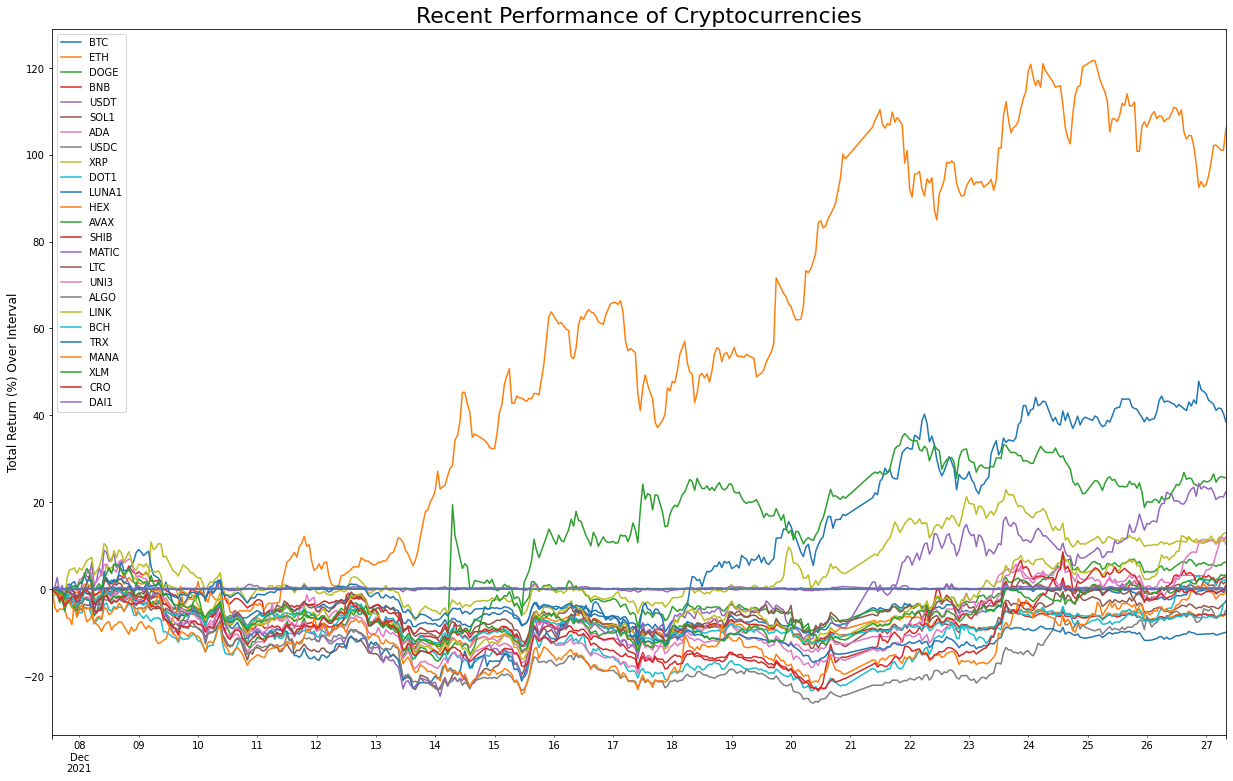

In [ ]:
coins=[c for c in list(data) if ord(c[0])>=ord('A') and ord(c[0])<=ord('Z') and '_' not in c]
data=data.tail(data.shape[0]-1)

for coin in coins:
    data[coin+"_total"]=data[coin]/data.loc[data.index[0],coin]*1e2-1e2

figure,plots=plot.subplots(figsize=(13*golden_ratio,13));

for coin in coins:
  data[coin+"_total"].plot(ax=plots,label=coin);

plots.set_title("Recent Performance of Cryptocurrencies",fontsize=22);
plots.axhline(0,alpha=0.5);
plots.set_ylabel("Total Return (%) Over Interval",fontsize=12);
plots.legend();

In [ ]:
source

'https://s3.amazonaws.com/public.gillerinvestments.com/crypto-of-the-hour.json'